In [1]:
import os
import difflib
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
cwd = os.getcwd()
main_table = pd.read_csv(os.path.join(cwd, '../MainTable.csv'))

main_table.head()

,Order,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,CourseSectionID,TermID,AssignmentID,ProblemID,...,CodeStateID,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,ParentEventID,SourceLocation
0,0,14502,Java 8; CodeWorkout,2019-03-20T19:34:25,0,CS 1114,410.0,spring-2019,492.0,32,...,1804399,True,Run.Program,1.0,NaN,NaN,NaN,32-84779,NaN,NaN
1,1,14502,Java 8; CodeWorkout,2019-03-20T19:34:25,0,CS 1114,410.0,spring-2019,492.0,32,...,1804399,True,Compile,NaN,Success,NaN,NaN,32-84780,32-84779,NaN
2,2,13504,Java 8; CodeWorkout,2019-03-20T21:02:00,0,CS 1114,407.0,spring-2019,492.0,32,...,1805146,True,Run.Program,1.0,NaN,NaN,NaN,32-84781,NaN,NaN
3,3,13504,Java 8; CodeWorkout,2019-03-20T21:02:00,0,CS 1114,407.0,spring-2019,492.0,32,...,1805146,True,Compile,NaN,Success,NaN,NaN,32-84782,32-84781,NaN
4,4,13499,Java 8; CodeWorkout,2019-03-20T21:13:09,0,CS 1114,410.0,spring-2019,492.0,32,...,1805216,True,Run.Program,0.0,NaN,NaN,NaN,32-84783,NaN,NaN


In [3]:
main_table['AssignmentID+ProblemID'] = main_table['AssignmentID'].astype(str) + " " + main_table['ProblemID'].astype(str)
subtable = main_table[['Order', 'SubjectID', 'ServerTimestamp', 'CourseSectionID', 'AssignmentID+ProblemID', 'CodeStateID', 'Score']]
subtable = subtable.drop_duplicates(subset=['CodeStateID'], keep='first')

In [4]:
df = subtable.groupby(['SubjectID', 'CourseSectionID', 'AssignmentID+ProblemID']).apply(lambda x: pd.Series({
    'CodeStateID': x['CodeStateID'].tolist(),
    'Score': x['Score'].tolist(),
    'ServerTimestamp': x['ServerTimestamp'].tolist(),
})).reset_index()

df['num_snapshots'] = df['CodeStateID'].apply(lambda x: len(x))
df['time_to_solve'] = df['ServerTimestamp'].apply(lambda x: (pd.to_datetime(x[-1]) - pd.to_datetime(x[0])).seconds)
df['time_between_snapshots'] = df['ServerTimestamp'].apply(lambda x: [(pd.to_datetime(x[i]) - pd.to_datetime(x[i-1])).seconds for i in range(1, len(x))])
df['success'] = df['Score'].apply(lambda x: 1 if x[-1] == 1 else 0)

Details on Data:

In [5]:
number_of_snapshots = df['num_snapshots'].sum()
number_of_students = df['SubjectID'].nunique()
number_of_assignments = df['AssignmentID+ProblemID'].nunique()
number_of_sections = df['CourseSectionID'].nunique()
unique_student_problem_combinations_count  = df.groupby(['SubjectID', 'AssignmentID+ProblemID']).size().reset_index(name='counts').shape[0] # how many problems and students
print(f"Number of snapshots: {number_of_snapshots}")
print(f"Number of students: {number_of_students}")
print(f"Number of assignments: {number_of_assignments}")
print(f"Number of sections: {number_of_sections}")
print(f"Number of students and problems: {unique_student_problem_combinations_count}")

Number of snapshots: 69627
Number of students: 413
Number of assignments: 50
Number of sections: 2
Number of students and problems: 16179


#### Quetion per Student

(array([  9.,  27.,   9.,  18.,   5.,  33.,  11.,  73.,  25., 203.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <BarContainer object of 10 artists>)

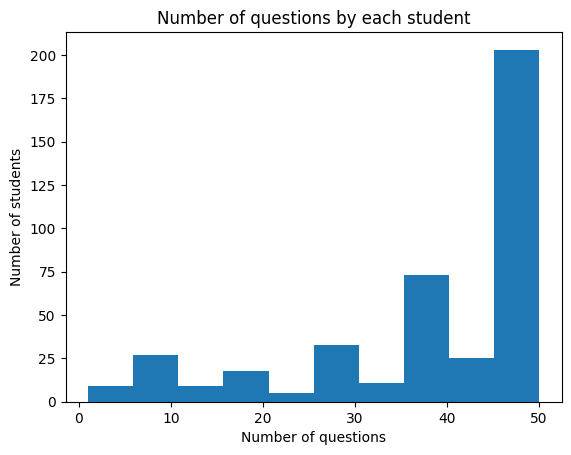

In [6]:
x = sorted(df.groupby('SubjectID')['AssignmentID+ProblemID'].nunique())
plt.title('Number of questions by each student')
plt.xlabel('Number of questions')
plt.ylabel('Number of students')
plt.hist(x)

#### Successful

In [7]:
df['Max.Score'] = df['Score'].apply(lambda x: max(x))
successfull = df[df['Max.Score'] == 1]
not_successfull = df[df['Max.Score'] < 1]
len(successfull), len(not_successfull)

(15024, 1155)

#### Snapshots per Student

In [8]:
snapshot_stat = df.groupby(['AssignmentID+ProblemID']).apply(lambda x: pd.Series({
    'number_of_students': x['SubjectID'].nunique(), 
    'min_snapshots': x['num_snapshots'].min(),
    'max_snapshots': x['num_snapshots'].max(),
    'mean_snapshots': x['num_snapshots'].mean(),
    'median_snapshots': x['num_snapshots'].median(),
})).reset_index()

snapshot_stat

,AssignmentID+ProblemID,number_of_students,min_snapshots,max_snapshots,mean_snapshots,median_snapshots
0,439.0 1,365.0,1.0,50.0,2.383562,2.0
1,439.0 12,362.0,1.0,75.0,2.182320,1.0
2,439.0 13,386.0,1.0,69.0,8.784974,6.0
3,439.0 232,378.0,1.0,51.0,5.973545,3.0
4,439.0 233,364.0,1.0,35.0,3.184066,2.0
5,439.0 234,367.0,1.0,24.0,3.190736,2.0
6,439.0 235,370.0,1.0,27.0,3.262162,2.0
7,439.0 236,366.0,1.0,28.0,3.243169,2.0
8,439.0 3,363.0,1.0,32.0,3.619835,2.0
9,439.0 5,365.0,1.0,31.0,3.471233,2.0


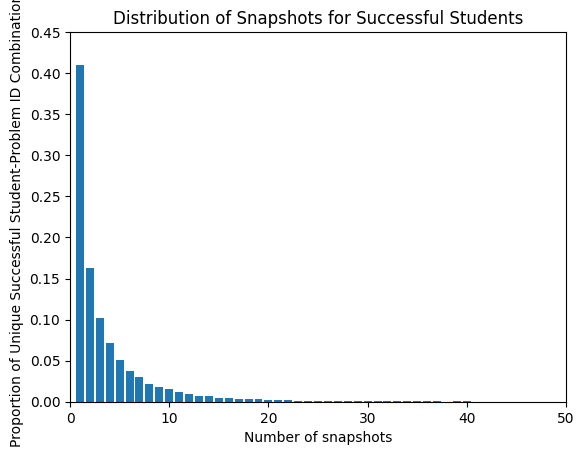

In [9]:
plt.title('Distribution of Snapshots for Successful Students')
plt.xlabel('Number of snapshots')
plt.ylabel('Proportion of Unique Successful Student-Problem ID Combinations')
plt.xlim(0, 50)
plt.ylim(0, 0.45)

success = df[df['success'] == 1]['num_snapshots']
success = success.value_counts(normalize=True).sort_index()
plt.bar(success.index, success.values)
plt.show()

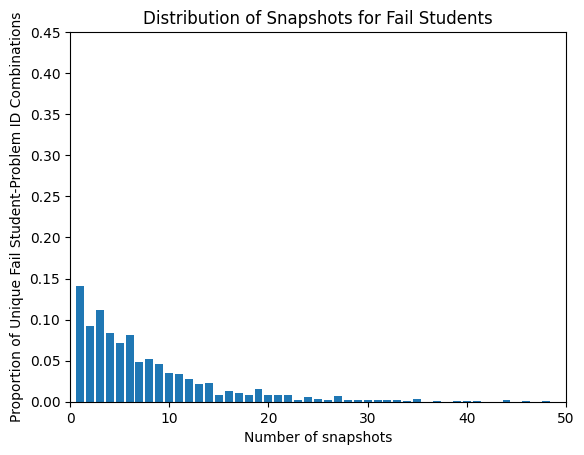

In [10]:
plt.title('Distribution of Snapshots for Fail Students')
plt.xlabel('Number of snapshots')
plt.ylabel('Proportion of Unique Fail Student-Problem ID Combinations')
plt.xlim(0, 50)
plt.ylim(0, 0.45)

fail = df[df['success'] == 0]['num_snapshots']
fail = fail.value_counts(normalize=True).sort_index()
plt.bar(fail.index, fail.values)
plt.show()

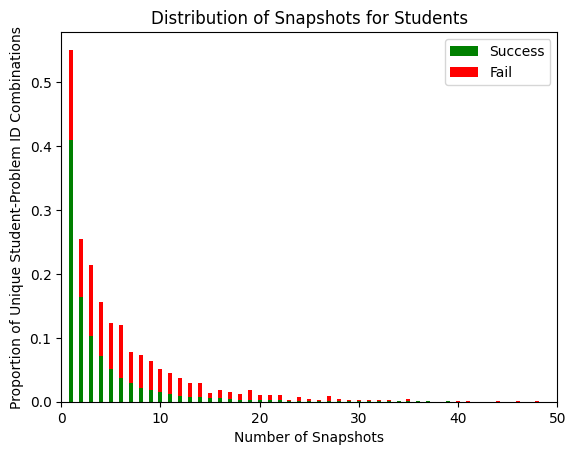

In [11]:
combined_index = success.index.union(fail.index)
success = success.reindex(combined_index, fill_value=0)
fail = fail.reindex(combined_index, fill_value=0)

plt.xlim(0, 50)

bar_width = 0.4
plt.bar(combined_index, success.values, width=bar_width, color='g', label='Success')
plt.bar(combined_index, fail.values, bottom=success.values, width=bar_width, color='r', label='Fail')

plt.title('Distribution of Snapshots for Students')
plt.xlabel('Number of Snapshots')
plt.ylabel('Proportion of Unique Student-Problem ID Combinations')
plt.legend()
plt.show()

#### Time

In [12]:
df_without_one_snapshot = df[df['num_snapshots'] > 1]
time_stat = df_without_one_snapshot.groupby(['AssignmentID+ProblemID']).apply(lambda x: pd.Series({
    'number_of_students': x['SubjectID'].nunique(), 
    'min_time_to_solve': x['time_to_solve'].min()/60,
    'max_time_to_solve': x['time_to_solve'].max()/60,
    'mean_time_to_solve': x['time_to_solve'].mean()/60,
    'median_time_to_solve': x['time_to_solve'].median()/60,
    'mean_time_between_snapshots': x['time_between_snapshots'].apply(lambda y: sum(y) / len(y)).mean()/60,
    'median_time_between_snapshots': x['time_between_snapshots'].apply(lambda y: sum(y) / len(y)).median()/60,
})).reset_index()

time_stat # in minutes

,AssignmentID+ProblemID,number_of_students,min_time_to_solve,max_time_to_solve,mean_time_to_solve,median_time_to_solve,mean_time_between_snapshots,median_time_between_snapshots
0,439.0 1,185.0,0.016667,1405.200000,19.864234,0.683333,5.538855,0.438333
1,439.0 12,141.0,0.083333,1400.300000,29.915839,0.550000,13.180828,0.400000
2,439.0 13,326.0,0.150000,1397.016667,111.194018,10.200000,13.033900,1.706250
3,439.0 232,284.0,0.083333,1415.950000,44.804695,3.275000,6.949188,0.767917
4,439.0 233,209.0,0.050000,321.516667,9.593780,1.833333,4.094979,0.737500
5,439.0 234,229.0,0.100000,1426.050000,21.981514,1.433333,9.819502,0.570833
6,439.0 235,228.0,0.133333,1174.966667,20.677778,2.483333,3.412073,0.990833
7,439.0 236,230.0,0.000000,1269.350000,14.428406,2.116667,2.522070,0.706173
8,439.0 3,223.0,0.000000,1183.283333,24.195516,2.650000,4.086803,0.871429
9,439.0 5,208.0,0.000000,1410.533333,22.114343,2.350000,8.900460,0.793750


#### Changes in Lines between Snapshots

In [13]:
cwd = os.getcwd()
code = pd.read_csv(os.path.join(cwd, '../LinkTables/CodeStates.csv'))

In [14]:
df_with_snapshots = df_without_one_snapshot
snapshots = []
for i in df_without_one_snapshot['CodeStateID']:
    snapshots_student = []
    for j in i:
        snapshots_student.append(code[code['CodeStateID'] == j]['Code'].values[0])
    snapshots.append(snapshots_student)

df_with_snapshots['Snapshots'] = snapshots

/tmp/ipykernel_19011/4233382148.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_snapshots['Snapshots'] = snapshots


In [15]:
def get_diffs(snapshots):
    diffs = []
    for i in range(1, len(snapshots)):
        diff = difflib.unified_diff(snapshots[i-1].splitlines(), snapshots[i].splitlines())
        diffs.append(list(diff))
    return diffs

df_with_snapshots['diffs'] = df_with_snapshots['Snapshots'].apply(lambda x: get_diffs(x))

/tmp/ipykernel_19011/2043892740.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_snapshots['diffs'] = df_with_snapshots['Snapshots'].apply(lambda x: get_diffs(x))


In [16]:
def get_deleted_inserted_lines(diffs):
    deleted = []
    inserted = []
    for diff in diffs:
        del_lines = 0
        ins_lines = 0
        for line in diff:
            if line.startswith('-'):
                del_lines += 1
            elif line.startswith('+'):
                ins_lines += 1
        deleted.append(del_lines)
        inserted.append(ins_lines)
    return deleted, inserted

df_with_snapshots['deleted'], df_with_snapshots['inserted'] = zip(*df_with_snapshots['diffs'].apply(lambda x: get_deleted_inserted_lines(x)))

/tmp/ipykernel_19011/2492576951.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_snapshots['deleted'], df_with_snapshots['inserted'] = zip(*df_with_snapshots['diffs'].apply(lambda x: get_deleted_inserted_lines(x)))
/tmp/ipykernel_19011/2492576951.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_snapshots['deleted'], df_with_snapshots['inserted'] = zip(*df_with_snapshots['diffs'].apply(lambda x: get_deleted_inserted_lines(x)))


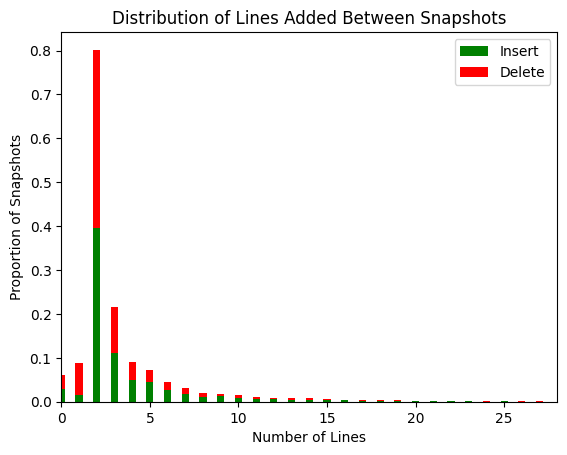

In [17]:
inserted = df_with_snapshots['inserted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots
deleted = df_with_snapshots['deleted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots

combined_index = inserted.index.union(deleted.index)
inserted = inserted.reindex(combined_index, fill_value=0)
deleted = deleted.reindex(combined_index, fill_value=0)

bar_width = 0.4

plt.bar(combined_index, inserted.values, width=bar_width, color='g', label='Insert')
plt.bar(combined_index, deleted.values, bottom=inserted.values, width=bar_width, color='r', label='Delete')

plt.xlim(0, 28)
plt.title('Distribution of Lines Added Between Snapshots')
plt.xlabel('Number of Lines')
plt.ylabel('Proportion of Snapshots')
plt.legend()
plt.show()

I decided to define the number of changed lines as the maximum between the inserted lines and the deleted lines.

In [18]:
# Look on specific quetions
question = '487.0 102'
specific_quetion_success = df_with_snapshots[(df_with_snapshots['AssignmentID+ProblemID'] == question) & (df_with_snapshots['num_snapshots'] >= 8) & (df_with_snapshots['num_snapshots'] <= 10) & (df_with_snapshots['success'] == 1)]
specific_quetion_success = specific_quetion_success.head(8)

specific_quetion_fail = df_with_snapshots[(df_with_snapshots['AssignmentID+ProblemID'] == question) & (df_with_snapshots['num_snapshots'] >= 8) & (df_with_snapshots['num_snapshots'] <= 10) & (df_with_snapshots['success'] == 0)]
specific_quetion_fail = specific_quetion_fail.head(8)

In [19]:
def plot_snapshot(specific_quetion):
    for index, row in specific_quetion.iterrows():
        snapshots = list(range(1, row['num_snapshots']))
        plt.plot(snapshots, max(row['deleted'], row['inserted']), marker='o', label=row['SubjectID'])

    plt.xlabel('Snapshots')
    plt.ylabel('Changed Lines')
    plt.title('Changed Lines over Snapshots')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


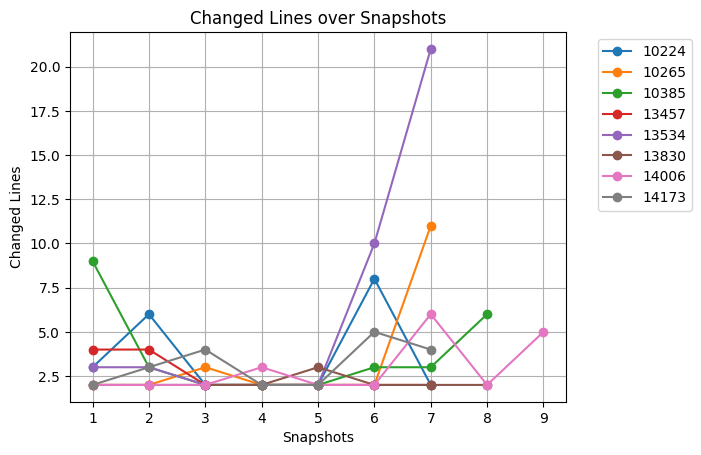

In [20]:
plot_snapshot(specific_quetion_success)

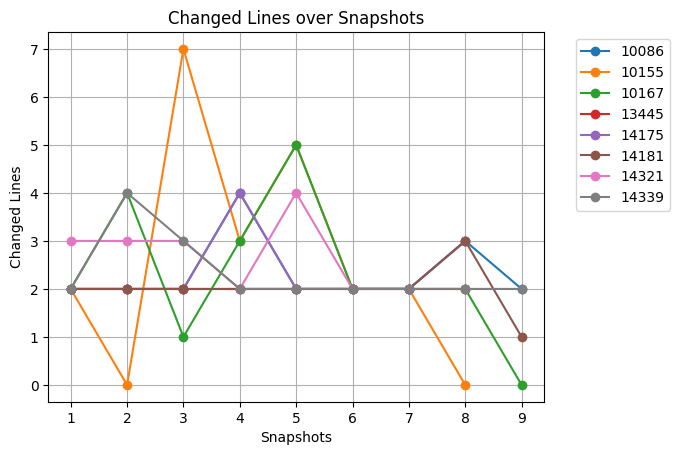

In [21]:
plot_snapshot(specific_quetion_fail)

#### Score between Snapshots

In [22]:
# Look on specific quetions
question = '487.0 102'
specific_quetion_success = df[(df['AssignmentID+ProblemID'] == question) & (df['num_snapshots'] >= 5) & (df['num_snapshots'] <= 10) & (df['success'] == 1)]
specific_quetion_success = specific_quetion_success.head(8)
specific_quetion_fail = df[(df['AssignmentID+ProblemID'] == question) & (df['num_snapshots'] >= 5) & (df['num_snapshots'] <= 10) & (df['success'] == 0)]
specific_quetion_fail = specific_quetion_fail.head(8)

In [23]:
def plot_snapshot(specific_quetion):
    for index, row in specific_quetion.iterrows():
        snapshots = list(range(1, row['num_snapshots'] + 1))
        plt.plot(snapshots, row['Score'], marker='o', label=row['SubjectID'])

    plt.xlabel('Snapshots')
    plt.ylabel('Scores')
    plt.title('Scores over Snapshots')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


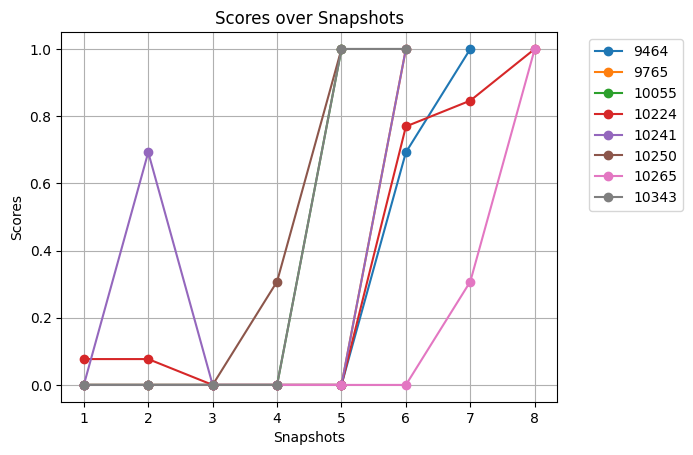

In [24]:
plot_snapshot(specific_quetion_success)

#### Explore Students Who not Finish The Question

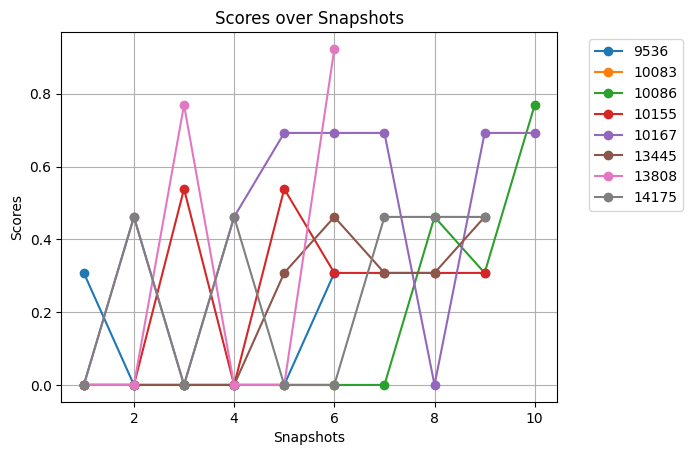

In [25]:
plot_snapshot(specific_quetion_fail)

In [35]:
a = df_with_snapshots[(df_with_snapshots['SubjectID'] == 13808) & (df_with_snapshots['AssignmentID+ProblemID'] == '487.0 102')]['Snapshots'].iloc[0]
for i in a:
    print(i)

public String without2(String str) 
{
    int string = str.length();
    if (string == 2) {
        return "";
    }
    else if (str.substring(0, 2).equals(str.substring(string - 2 , string)) {
        return str.substring(2, string);
    }
    else {
        return string;
    }
}

public String without2(String str) 
{
    int string = str.length();
    if (string == 2) {
        return "";
    }
    else if (str.substring(0, 2).equals(str.substring(string - 2 , string))) {
        return str.substring(2, string);
    }
    else {
        return string;
    }
}

public String without2(String str) 
{
    int string = str.length();
    if (string == 2) {
        return "";
    }
    else if (str.substring(0, 2).equals(str.substring(string - 2 , string))) {
        return str.substring(2, string);
    }
    else {
        return str;
    }
}

public String without2(String str) 
{
    int string = str.length();
    if (string == 2) {
        return "";
    }
    else if (str.substring(0,

In [27]:
df_fail = df[df['success'] == 0]

snapshots_vs_score = {}
for index, row in df_fail.iterrows():
    if row['AssignmentID+ProblemID'] not in snapshots_vs_score:
        snapshots_vs_score[row['AssignmentID+ProblemID']] = {}
    for i in range (1, row['num_snapshots'] + 1):
        if i not in snapshots_vs_score[row['AssignmentID+ProblemID']]:
            snapshots_vs_score[row['AssignmentID+ProblemID']][i] = []
        snapshots_vs_score[row['AssignmentID+ProblemID']][i].append(row['Score'][i - 1])

avg_snapshots_vs_score = {}
len_snapshots_vs_score = {}
for key, value in snapshots_vs_score.items():
    avg_snapshots_vs_score[key] = {}
    len_snapshots_vs_score[key] = {}
    for k, v in value.items():
        avg_snapshots_vs_score[key][k] = sum(v) / len(v)
        len_snapshots_vs_score[key][k] = len(v)

data = []

# Iterate over items in avg_snapshots_vs_score
for key, value in avg_snapshots_vs_score.items():
    for k, v in value.items():
        # Append a dictionary to the list
        data.append({'AssignmentID+ProblemID': key, 'Snapshot': k, 'Average Score': v, 'Number of Students': len_snapshots_vs_score[key][k]})

df_snapshots_vs_score = pd.DataFrame(data)
df_snapshots_vs_score

,AssignmentID+ProblemID,Snapshot,Average Score,Number of Students
0,487.0 25,1,0.234014,35
1,487.0 25,2,0.248848,31
2,487.0 25,3,0.374384,29
3,487.0 25,4,0.277778,24
4,487.0 25,5,0.482402,23
...,...,...,...,...
1329,487.0 17,8,0.000000,1
1330,487.0 17,9,0.346154,1
1331,487.0 17,10,0.000000,1
1332,487.0 17,11,0.615385,1


In [28]:
# arrange by limit to 10 snapshots and at least 5 students
df_snapshots_vs_score_10 = df_snapshots_vs_score[(df_snapshots_vs_score['Snapshot'] <= 10) & (df_snapshots_vs_score['Number of Students'] >= 5)]

In [29]:
df_all = df_snapshots_vs_score.groupby('Snapshot').apply(lambda x: pd.Series({
    'mean_score': x['Average Score'].mean(),
    'number_of_students': x['Number of Students'].sum(),
})).reset_index()

The mean score is problemtic (The number of student is decrease)

<Axes: title={'center': 'Score of Student not Finish the Question by Snapshots'}, xlabel='Snapshots', ylabel='Mean Score'>

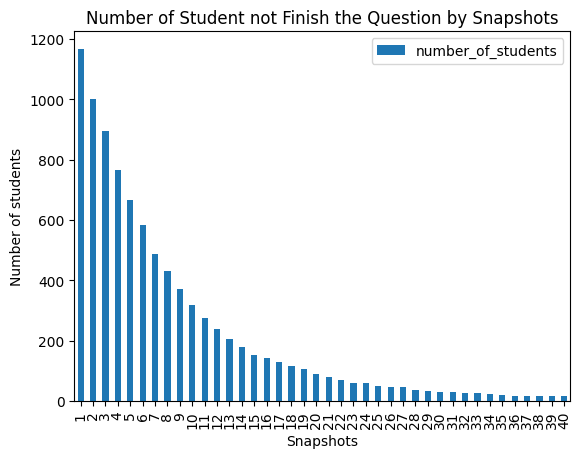

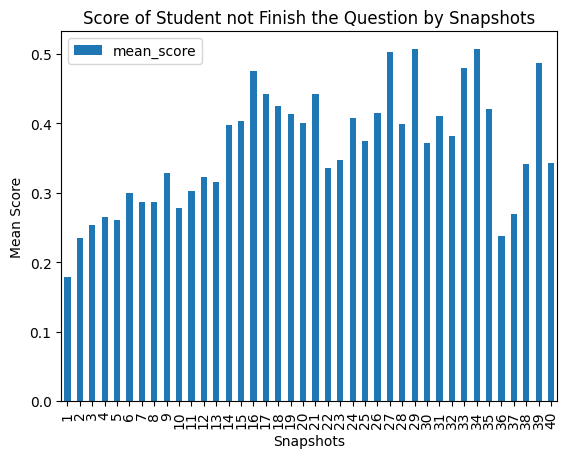

In [30]:
df_snapshots_vs_score_40 = df_all.head(40)
df_snapshots_vs_score_40.plot(x='Snapshot', y='number_of_students', kind='bar', xlabel='Snapshots', ylabel='Number of students', title='Number of Student not Finish the Question by Snapshots')
df_snapshots_vs_score_40.plot(x='Snapshot', y='mean_score', kind='bar', xlabel='Snapshots', ylabel='Mean Score', title='Score of Student not Finish the Question by Snapshots')


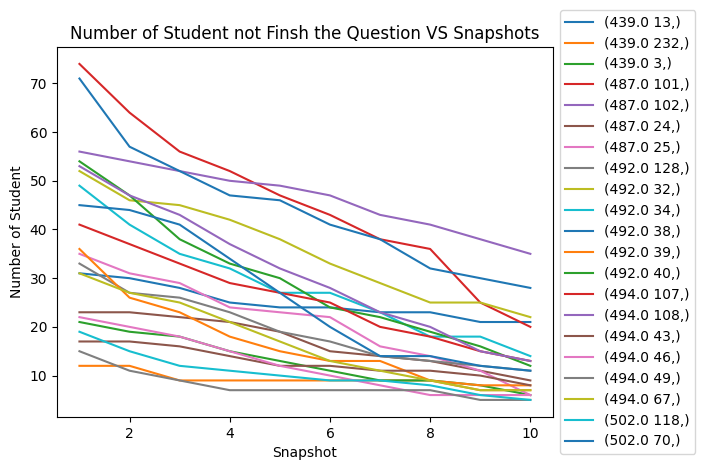

In [31]:
df_filter_snapshots_vs_score_10 = df_snapshots_vs_score_10.groupby('AssignmentID+ProblemID').filter(lambda x: len(x) == 10)
fig, ax = plt.subplots()
for key, grp in df_filter_snapshots_vs_score_10.groupby(['AssignmentID+ProblemID']):
    ax = grp.plot(ax=ax, kind='line', x='Snapshot', y='Number of Students', ylabel='Number of Student', title='Number of Student not Finsh the Question VS Snapshots',  label=key)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))